<a href="https://colab.research.google.com/github/ShamsulAbedin/CA684I/blob/master/Shamsul_CA684I_kaggle_MediaEval_Caption_C3D_HMP_testing_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting video memorability using captions**


#1  FUNCTIONS DEFINITION

Here we are defining necessary functions required.

##1.1 : C3D Feature

In [0]:
#Function to load C3D features

def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D

## 1.2 : HMP features

In [0]:
#Function to load HMP features
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

## 1.3 : Captions into dataframes

In [0]:
#Function to load the captions into dataframes
def read_caps(filename):
    video_name = []
    captions = []
    df_caption = pd.DataFrame()
    with open(filename) as file:
        for line in file:
            pair = line.split() #each line in the text file contains to words so, this code will split them into two words
            video_name.append(pair[0]) #first word will be assigned as video name
            captions.append(pair[1]) #second word will be assigned as caption
        df_caption['video']=video_name #setting these two as column names of dataframe
        df_caption['caption']=captions
    return df_caption


## 1.4 : Spearman coefficient scores

In [0]:
#Function to calculate Spearman coefficient scores
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

#2 Loading Package & Libraries

## 2.1 : Installing packages

In [4]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 49kB/s 
     |████████████████████████████████| 3.2MB 27.1MB/s 
     |████████████████████████████████| 491kB 42.5MB/s 
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


In [0]:
!pip show tensorflow

Name: tensorflow
Version: 1.14.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, gast, six, tensorboard, tensorflow-estimator, grpcio, wrapt, absl-py, astor, protobuf, keras-applications, wheel, google-pasta, termcolor, keras-preprocessing
Required-by: fancyimpute


In [5]:
!pip install pyprind
!pip install keras

## 2.2 : Inporting Libraries

In [0]:
import pandas as pd

import numpy as np
from string import punctuation
import matplotlib.pyplot as plt
import os


In [7]:
from keras import Sequential
from keras import layers
from keras import regularizers
import tensorflow
from tensorflow.python.keras import Sequential
from tensorflow.python.keras import layers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.preprocessing.text import Tokenizer
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [0]:
# for reproducability
from numpy.random import seed
seed(1)

In [0]:
import tensorflow
from tensorflow import set_random_seed
tensorflow.set_random_seed(1)

#3 Loading Video Memorability files and Features

##3.1 : Mounting Drive

In [10]:
import os
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


##3.2 : Loading Features

In [0]:
#load the ground truth dataset
path_label = '/content/drive/My Drive/CA684_Assignment/Dev-set/Ground-truth/'
labels=pd.read_csv(path_label+'ground-truth.csv')

In [0]:
#load captions
caption_path='/content/drive/My Drive/CA684_Assignment/Dev-set/Captions/dev-set_video-captions.txt'
df_caption=read_caps(caption_path)

In [0]:
#load C3D features

Feature_path_C3D = '/content/drive/My Drive/CA684_Assignment/Dev-set/'
# Load video related features first
# it helps with the organization of the video names
vid = labels.video.values

Feature_C3D = pd.DataFrame({'video': vid,
                   'C3D': [read_C3D(Feature_path_C3D+'C3D'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid],
                       })

In [0]:
#load HMP features

Feature_path_HMP = '/content/drive/My Drive/CA684_Assignment/Dev-set/'
# Load video related features first
# it helps with the organization of the video names
vid = labels.video.values
Feature_HMP = pd.DataFrame({'video': vid,
                   'HMP': [read_HMP(Feature_path_HMP+'HMP'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid],
                       })

In [150]:
print(df_caption)

               video                                            caption
0        video3.webm                 blonde-woman-is-massaged-tilt-down
1        video4.webm  roulette-table-spinning-with-ball-in-closeup-shot
2        video6.webm                                      khr-gangsters
3        video8.webm               medical-helicopter-hovers-at-airport
4       video10.webm               couple-relaxing-on-picnic-crane-shot
...              ...                                                ...
5995  video7488.webm        beautiful-young-woman-in-front-of-fountains
5996  video7489.webm  focus-pull-from-molting-penguin-to-penguin-col...
5997  video7491.webm           students-walking-in-university-of-mexico
5998  video7492.webm                       beautiful-black-woman-at-spa
5999  video7493.webm  beautiful-modern-brunette-woman-using-tablet-c...

[6000 rows x 2 columns]


In [0]:
#shape of the dataframes
print(f'Ground Truth : {labels.shape}')
print(f'Dev Captions : {df_caption.shape}')
print(f'C3D          : ({len(Feature_C3D)})')
print(f'HMP          : ({len(Feature_HMP)})')

##3.3 : Joining the dataframes

In [151]:
df = df_caption.merge(labels,on=["video"],how="inner")
df

,video,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,blonde-woman-is-massaged-tilt-down,0.924,34,0.846,13
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot,0.923,33,0.667,12
2,video6.webm,khr-gangsters,0.863,33,0.700,10
3,video8.webm,medical-helicopter-hovers-at-airport,0.922,33,0.818,11
4,video10.webm,couple-relaxing-on-picnic-crane-shot,0.950,34,0.900,10
...,...,...,...,...,...,...
5995,video7488.webm,beautiful-young-woman-in-front-of-fountains,0.921,33,1.000,9
5996,video7489.webm,focus-pull-from-molting-penguin-to-penguin-col...,0.909,53,0.839,31
5997,video7491.webm,students-walking-in-university-of-mexico,0.713,33,0.818,11
5998,video7492.webm,beautiful-black-woman-at-spa,0.954,34,1.000,16


#4 Pre-Processing Stage

##4.1 Remove punctuation

In [152]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [0]:

#function to remove punctuation
def remove_punct(text):
  text_nopunct="".join([char for char in text if char not in string.punctuation])  #it will discard all punctuation
  return text_nopunct

In [154]:
df['body_text_clean']=df['caption'].apply(lambda x: remove_punct(x))
df.head()

,video,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations,body_text_clean
0,video3.webm,blonde-woman-is-massaged-tilt-down,0.924,34,0.846,13,blondewomanismassagedtiltdown
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot,0.923,33,0.667,12,roulettetablespinningwithballincloseupshot
2,video6.webm,khr-gangsters,0.863,33,0.700,10,khrgangsters
3,video8.webm,medical-helicopter-hovers-at-airport,0.922,33,0.818,11,medicalhelicopterhoversatairport
4,video10.webm,couple-relaxing-on-picnic-crane-shot,0.950,34,0.900,10,couplerelaxingonpicniccraneshot


## 4.2 Removing Stopwords


In [155]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
stop = stopwords.words('english') 

## 4.3 Lemmatization


In [157]:
df['caption_lem'] = df['body_text_clean'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df['caption_lem'].head()

0                 blondewomanismassagedtiltdown
1    roulettetablespinningwithballincloseupshot
2                                  khrgangsters
3              medicalhelicopterhoversatairport
4               couplerelaxingonpicniccraneshot
Name: caption_lem, dtype: object

## 4.4 Extracting unique words count

In [0]:
word_counts = Counter()
for i, captions in enumerate(df['caption_lem']):
    word_counts.update(captions.split())

In [159]:
df.caption_lem.values

array(['blondewomanismassagedtiltdown',
       'roulettetablespinningwithballincloseupshot', 'khrgangsters', ...,
       'studentswalkinginuniversityofmexico', 'beautifulblackwomanatspa',
       'beautifulmodernbrunettewomanusingtabletcomputerinluxurybed'],
      dtype=object)

##	2.5 Caption: n-Gram approach- Using TF-IDF Vectorizer

In [160]:

vect_tfidf=TfidfVectorizer(ngram_range = (1,4)).fit(df.caption_lem)
vect_transformed_X_train=vect_tfidf.fit_transform(df['caption_lem'])
token_len = len(vect_tfidf.get_feature_names())
token_len

5198

##	2.6 Maping each unique word to an integer using one-hot encoding

In [0]:
# build the word index
token_len = len(word_counts)
tokenizer = Tokenizer(num_words=token_len)


In [0]:
#fit a list of captions to the tokenizer
#the tokenizer vectorizes a text corpus, by turning each text into either a sequence of integers 

tokenizer.fit_on_texts(list(vect_tfidf.get_feature_names()))

In [0]:
#sequences = tokenizer.texts_to_sequences(list(df.caption_lem.values))

onehot_encode = tokenizer.texts_to_matrix(list(df.caption_lem.values),mode='binary')


In [164]:
len(onehot_encode)

6000

In [165]:
onehot_encode.shape

(6000, 5198)

**Combining Captions and C3D into a single Vector**

In [0]:
captions_c3d = (captions_bag.tolist())
counter = 0
for item in range(6000):
    captions_c3d[counter] = np.append(captions_c3d[counter],c3dfeatures[counter],axis=0)
    counter = counter+1

In [0]:
len(captions_c3d[0]) 

5188

In [0]:
len(captions_c3d)

6000

**Combining Captions+C3D+HMP**

In [0]:
#Combining captions_c3d with HMP to form 
captions_c3d_hmp = captions_c3d
counter = 0
for item in range(6000):
    captions_c3d_hmp[counter] = np.append(captions_c3d_hmp[counter],hmp_features[counter],axis=0)
    counter = counter+1

In [0]:
len(captions_c3d_hmp[0]) 

11263

In [0]:
len(captions_c3d_hmp)

6000

Now we have the following features

1.   Captions in: captions_bag
2.   C3D in: c3dfeatures 
3.   HMP in: hmp_features
4.   Captions and C3D:&nbsp;  captions_c3d
5.   Captions, C3D and HMP in: captions_c3d_hmp

##2.7 Model

In [0]:
from keras.layers import Activation, Dense
from keras.models import Model

In [0]:
Y=df[['short-term_memorability','long-term_memorability']].values  #targets
X=X_counts_seq #input

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [0]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 5019)
X_test (1200, 5019)
Y_train (4800, 2)
Y_test (1200, 2)


In [0]:
n_cols = X_train.shape[1]
n_cols

5019

In [0]:
#from keras import layers
#from keras.layers import Dropout



model = Sequential()

model.add(layers.Dense(220,activation='relu',kernel_regularizer=None,input_shape=(n_cols,)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(220,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2,activation='sigmoid'))
model.summary()



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 220)               1104400   
_________________________________________________________________
dropout (Dropout)            (None, 220)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 220)               48620     
_________________________________________________________________
dropout_1 (Dropout)          (None, 220)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 442       
Total params: 1,153,462
Trainable params: 1,153,462
Non-trainable params: 0
__________________________________________________________

In [0]:
# Compiling the model
model.compile(optimizer='rmsprop', loss = 'mean_squared_error')

In [0]:
# Verifying that model contains information from compiling
print("Loss function: " + model.loss)


Loss function: mean_squared_error


In [0]:
# Fitting the model
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))


Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 2s 489us/sample - loss: 0.0656 - val_loss: 0.0148
Epoch 2/20
4800/4800 [==============================] - 3s 594us/sample - loss: 0.0134 - val_loss: 0.0141
Epoch 3/20
4800/4800 [==============================] - 3s 626us/sample - loss: 0.0125 - val_loss: 0.0136
Epoch 4/20
4800/4800 [==============================] - 2s 428us/sample - loss: 0.0119 - val_loss: 0.0138
Epoch 5/20
4800/4800 [==============================] - 2s 437us/sample - loss: 0.0116 - val_loss: 0.0139
Epoch 6/20
4800/4800 [==============================] - 2s 432us/sample - loss: 0.0112 - val_loss: 0.0143
Epoch 7/20
4800/4800 [==============================] - 2s 434us/sample - loss: 0.0109 - val_loss: 0.0143
Epoch 8/20
4800/4800 [==============================] - 2s 427us/sample - loss: 0.0105 - val_loss: 0.0147
Epoch 9/20
4800/4800 [==============================] - 2s 423us/sample - loss: 0.0101 - val_loss: 0.015


**Visualising the validation and training loss**

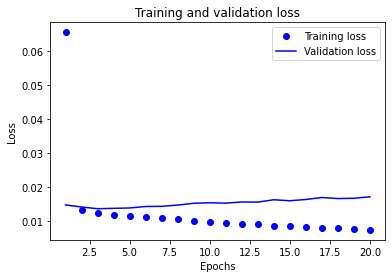

In [0]:

#Visualising the loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
predictions = model.predict(X_test)
print(predictions)
Get_score(predictions, Y_test) # Calculating Spearman scores which is best if the value is above 0.300

[[0.90477884 0.6996402 ]
 [0.90030813 0.8977151 ]
 [0.8499879  0.78274506]
 ...
 [0.9025229  0.91492206]
 [0.84545636 0.6859844 ]
 [0.8290882  0.6874543 ]]
The Spearman's correlation coefficient is: 0.446
The Spearman's correlation coefficient is: 0.149


In [0]:
predictions

array([[0.90477884, 0.6996402 ],
       [0.90030813, 0.8977151 ],
       [0.8499879 , 0.78274506],
       ...,
       [0.9025229 , 0.91492206],
       [0.84545636, 0.6859844 ],
       [0.8290882 , 0.6874543 ]], dtype=float32)

In [0]:
predictions.min(axis=0)

array([0.7056032 , 0.50051945], dtype=float32)

In [0]:
predictions.max(axis=0)

array([0.9540562, 0.9657255], dtype=float32)

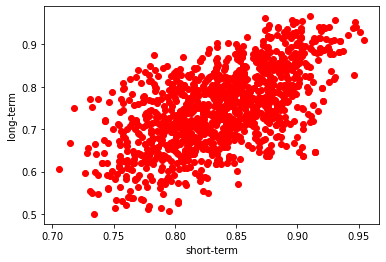

In [0]:

plt.figure()
plt.scatter(predictions[:,0],predictions[:,1],marker='o',c='r')
plt.xlabel('short-term')
plt.ylabel('long-term')
plt.savefig('Prediction_captions.eps')

In [0]:
import pandas as pd
prediction = pd.DataFrame(predictions, columns=['Short_term_score','Long_term_score']).to_csv('/content/drive/My Drive/predictions.csv')

In [0]:
model.save('/content/drive/My Drive/final_model_memory.h5')  # creates a HDF5 file 'final_model_memory.h5'

#x need to delete

## 2.2 Tokenization

In [0]:
import re

#function to tokenise

def tokenize(text):
  tokens=re.split('\W+',text)
  return tokens
df['tokenized_body']=df['caption'].apply(lambda x: tokenize(x.lower()))
df.head()

,video,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations,body_text_clean,tokenized_body
0,video3.webm,blonde woman is massaged tilt down,0.924,34,0.846,13,blonde woman is massaged tilt down,"[blonde, woman, is, massaged, tilt, down]"
1,video4.webm,roulette table spinning with ball in closeup shot,0.923,33,0.667,12,roulette table spinning with ball in closeup shot,"[roulette, table, spinning, with, ball, in, cl..."
2,video6.webm,khr gangsters,0.863,33,0.700,10,khr gangsters,"[khr, gangsters]"
3,video8.webm,medical helicopter hovers at airport,0.922,33,0.818,11,medical helicopter hovers at airport,"[medical, helicopter, hovers, at, airport]"
4,video10.webm,couple relaxing on picnic crane shot,0.950,34,0.900,10,couple relaxing on picnic crane shot,"[couple, relaxing, on, picnic, crane, shot]"


## 2.2 Vectorizing Data: Bag-Of-Words (Approach 1)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

# used to remove stopwords
count_vect=CountVectorizer(min_df=1, stop_words='english') 

In [0]:
X_counts=count_vect.fit_transform(df['caption'])
print(X_counts.shape)

(6000, 5019)


In [0]:
X_counts=count_vect.fit_transform(df['caption'])

In [0]:
X_counts_seq=X_counts.toarray()
X_counts_seq

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [0]:
print(X_counts_seq[0])

[0 0 0 ... 0 0 0]


In [0]:
token_len

77717

## 2.3 Vectorizing Data: TF-IDF (Approach 2)

**Gives less Spearman's corelation compare to Bag of Words**

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
#tfidf=TfidfVectorizer(min_df=1, stop_words='english')
#X_TFIDF=tfidf.fit_transform(df['caption'])
#X_seq=X_TFIDF.toarray()
#X_seq
#print(X_seq[0])

tfidf=TfidfVectorizer(min_df=1, stop_words='english')
X_TFIDF=tfidf.fit_transform(df['caption'])
X_seq=X_TFIDF.toarray()
X_seq
print(X_seq[0])

[0. 0. 0. ... 0. 0. 0.]


In [0]:
from nltk.stem import WordNetLemmatizer
from nltk import tokenize

import re

In [0]:
vect_tfidf=TfidfVectorizer(ngram_range = (1,4)).fit(df.caption)
vect_transformed_X_train=vect_tfidf.fit_transform(df['caption'])
token_len = len(vect_tfidf.get_feature_names())
token_len

77717

In [0]:
word_counts = Counter()
# setting up prograss tracker
pbar = pyprind.ProgBar(len(df_caption['caption']), title='Calculating word occurrences')
for i, captions in enumerate(df_caption['caption']):
    # replacing the punctuations with spaces
    # converting the words with lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in captions]).lower()
    df_caption.loc[i,'caption'] = text
    pbar.update()
    word_counts.update(text.split())

Calculating word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [0]:
df_caption.head()

,video,caption
0,video3.webm,blonde woman is massaged tilt down
1,video4.webm,roulette table spinning with ball in closeup shot
2,video6.webm,khr gangsters
3,video8.webm,medical helicopter hovers at airport
4,video10.webm,couple relaxing on picnic crane shot


In [0]:
labels.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


#	3 Predicting video memorability using captions

##	3.1 Recurrent Neural Network model

In [0]:
Y = labels[['short-term_memorability','long-term_memorability']].values
X = onehot_encode;
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [0]:
# add dropout
# add regularizers

model = Sequential()

model.add(layers.Dense(220,activation='relu',kernel_regularizer=None,input_shape=(token_len,)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(220,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2,activation='sigmoid'))
model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 220)               1143780   
_________________________________________________________________
dropout_2 (Dropout)          (None, 220)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 220)               48620     
_________________________________________________________________
dropout_3 (Dropout)          (None, 220)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 442       
Total params: 1,192,842
Trainable params: 1,192,842
Non-trainable params: 0
_________________________________________________________________


Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 2s 492us/sample - loss: 0.0687 - acc: 0.6917 - val_loss: 0.0166 - val_acc: 0.7100
Epoch 2/20
4800/4800 [==============================] - 2s 445us/sample - loss: 0.0142 - acc: 0.7038 - val_loss: 0.0140 - val_acc: 0.7100
Epoch 3/20
4800/4800 [==============================] - 2s 443us/sample - loss: 0.0131 - acc: 0.7035 - val_loss: 0.0138 - val_acc: 0.7100
Epoch 4/20
4800/4800 [==============================] - 2s 451us/sample - loss: 0.0124 - acc: 0.7035 - val_loss: 0.0140 - val_acc: 0.7100
Epoch 5/20
4800/4800 [==============================] - 2s 444us/sample - loss: 0.0121 - acc: 0.7035 - val_loss: 0.0141 - val_acc: 0.7100
Epoch 6/20
4800/4800 [==============================] - 2s 448us/sample - loss: 0.0116 - acc: 0.7038 - val_loss: 0.0145 - val_acc: 0.7100
Epoch 7/20
4800/4800 [==============================] - 2s 440us/sample - loss: 0.0111 - acc: 0.7035 - val_loss: 0.0145 - va

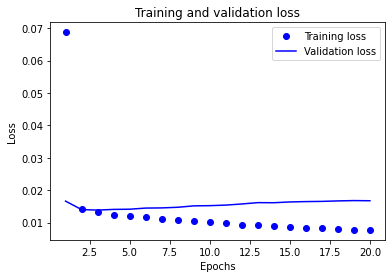

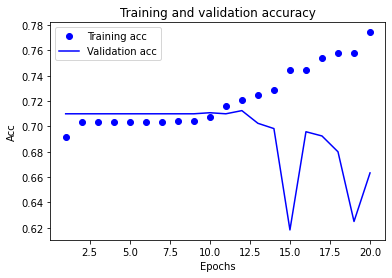

In [0]:
          
# compile the model 
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

# training the model 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

# visualizing the model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


In [0]:
predictions = model.predict(X_test)
print(predictions.shape)


(1200, 2)


In [138]:
predictions = model.predict(X_test)
print(predictions)
Get_score(predictions, Y_test) # Calculating Spearman scores which is best if the value is above 0.300

ValueError: ignored

In [0]:
Y_pred_train = model.predict(X_train)
#Y_pred_val = model.predict(X_test)

In [0]:
print('='*20)
Get_score(predictions, Y_test)

The Spearman's correlation coefficient is: 0.435
The Spearman's correlation coefficient is: 0.159


**Saving the model**

In [0]:
model.save('/content/drive/My Drive/my_model.h5')  # creates a HDF5 file 'my_model.h5'

##	3.2 Random Forest Model

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
rf3 = RandomForestRegressor(n_estimators = 10, random_state = 0).fit(X_train, Y_train);

In [0]:
y_predict = rf3.predict(X_test)
Get_score(y_predict, Y_test)


The Spearman's correlation coefficient is: 0.395
The Spearman's correlation coefficient is: 0.183


##	3.3 Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression



In [0]:
modelLR = LinearRegression().fit(X_train, Y_train)

In [0]:
ynew = modelLR.predict(X_test)
Get_score(y_predict, Y_test)

The Spearman's correlation coefficient is: 0.381
The Spearman's correlation coefficient is: 0.164


##	3.4 Support Vector Machines - SVR

### SVR-Short Term memorablity

In [0]:
from sklearn.svm import SVR
Y_short = labels[['short-term_memorability']].values
X = onehot_encode;
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=100).fit(X_train,Y_train_short)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### SVR-Long Term memorablity

In [0]:
Y_long = labels[['long-term_memorability']].values
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)


In [0]:
Y_test_long.shape
modelSVR_long = SVR(C=100).fit(X_train,Y_train_long)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)


NameError: ignored

##	3.5 Decision Tree

In [0]:
from sklearn.tree import DecisionTreeRegressor

In [0]:
regr = DecisionTreeRegressor(max_depth=10)
regr.fit(X_train, Y_train)
pred_test_dtr = regr.predict(X_test)


In [0]:
Get_score(pred_test_dtr, Y_test)

The Spearman's correlation coefficient is: 0.257
The Spearman's correlation coefficient is: 0.139


#4 Predicting video memorability using Video features



##	4.1 Using C3D feature

In [0]:
def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D

def vname2ID(vnames):
    """Parse video digital id from its name
    vnames: a list contains file names"""
    vid = [ os.path.splitext(video_name)[0]+'.webm' for video_name in vnames]
    return vid


In [0]:

model = Sequential()
model.add(layers.Dense(220,activation='relu',kernel_regularizer=None,input_shape=(HMP_X.shape[1],)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(220,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(2,activation='sigmoid'))
model.summary()

NameError: ignored

In [0]:
Feature_path_C3D = '/content/drive/My Drive/CA684_Assignment/Dev-set/'
# Load video related features first
# it helps with the organization of the video names
vid = labels.video.values

Feature_C3D = pd.DataFrame({'video': vid,
                   'C3D': [read_C3D(Feature_path_C3D+'C3D'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid],
                       })

KeyboardInterrupt: ignored

In [0]:
X_C3D = np.stack(Feature_C3D['C3D'].values)
Y_C3D = labels[['short-term_memorability','long-term_memorability']].values

X_C3D_train, X_C3D_test, Y_C3D_train, Y_C3D_test = train_test_split(X_C3D,Y_C3D, test_size=0.2, random_state=42)


###	4.1.1 Recurrent Neural Network

In [0]:
C3D_model = Sequential()
C3D_model.add(layers.Dense(200,activation='relu',kernel_regularizer=None,input_shape=(X_C3D.shape[1],)))
C3D_model.add(layers.Dropout(0.1))
C3D_model.add(layers.Dense(2,activation='sigmoid'))
C3D_model.compile(optimizer='rmsprop',loss=['mae'])
history=C3D_model.fit(x=X_C3D_train,y=Y_C3D_train,batch_size=50,epochs=20,validation_split=0.2,shuffle=True,verbose=True)
Y_C3D_pred = C3D_model.predict(X_C3D_test)



Train on 3840 samples, validate on 960 samples
Epoch 1/20
3840/3840 [==============================] - 0s 92us/sample - loss: 0.1565 - val_loss: 0.0868
Epoch 2/20
3840/3840 [==============================] - 0s 41us/sample - loss: 0.0872 - val_loss: 0.0863
Epoch 3/20
3840/3840 [==============================] - 0s 41us/sample - loss: 0.0867 - val_loss: 0.0865
Epoch 4/20
3840/3840 [==============================] - 0s 43us/sample - loss: 0.0862 - val_loss: 0.0864
Epoch 5/20
3840/3840 [==============================] - 0s 41us/sample - loss: 0.0862 - val_loss: 0.0868
Epoch 6/20
3840/3840 [==============================] - 0s 43us/sample - loss: 0.0859 - val_loss: 0.0866
Epoch 7/20
3840/3840 [==============================] - 0s 40us/sample - loss: 0.0857 - val_loss: 0.0875
Epoch 8/20
3840/3840 [==============================] - 0s 41us/sample - loss: 0.0855 - val_loss: 0.0874
Epoch 9/20
3840/3840 [==============================] - 0s 41us/sample - loss: 0.0852 - val_loss: 0.0876
Epoch 10

In [0]:
Get_score(Y_C3D_pred,Y_C3D_test)

The Spearman's correlation coefficient is: 0.280
The Spearman's correlation coefficient is: 0.120


###	4.1.2 Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor
C3D_clf = RandomForestRegressor()
C3D_clf.fit(X_C3D_train,Y_C3D_train)
pred_test_rfr = C3D_clf.predict(X_C3D_test)

In [0]:
Get_score(pred_test_rfr, Y_C3D_test)

NameError: ignored

##	4.2 Using HMP feature

In [0]:
X_HMP = np.stack(Feature_HMP['HMP'].values)
Y_HMP = labels[['short-term_memorability','long-term_memorability']].values
X_HMP_train, X_HMP_test, Y_HMP_train, Y_HMP_test = train_test_split(X_HMP,Y_HMP, test_size=0.2, random_state=42)


###	4.2.1 Recurrent Neural Network



In [0]:
HMP_model = Sequential()
HMP_model.add(layers.Dense(200,activation='relu',kernel_regularizer=None,input_shape=(X_HMP.shape[1],)))
HMP_model.add(layers.Dropout(0.1))
HMP_model.add(layers.Dense(2,activation='sigmoid'))
HMP_model.compile(optimizer='rmsprop',loss=['mae'])
history=HMP_model.fit(x=X_HMP_train,y=Y_HMP_train,batch_size=50,epochs=20,validation_split=0.2,shuffle=True,verbose=True)
Y_HMP_pred = HMP_model.predict(X_HMP_test)



Train on 3840 samples, validate on 960 samples
Epoch 1/20
3840/3840 [==============================] - 2s 427us/sample - loss: 0.1521 - val_loss: 0.0865
Epoch 2/20
3840/3840 [==============================] - 1s 359us/sample - loss: 0.0887 - val_loss: 0.0862
Epoch 3/20
3840/3840 [==============================] - 1s 353us/sample - loss: 0.0879 - val_loss: 0.0858
Epoch 4/20
3840/3840 [==============================] - 1s 360us/sample - loss: 0.0877 - val_loss: 0.0856
Epoch 5/20
3840/3840 [==============================] - 1s 366us/sample - loss: 0.0876 - val_loss: 0.0862
Epoch 6/20
3840/3840 [==============================] - 1s 362us/sample - loss: 0.0874 - val_loss: 0.0858
Epoch 7/20
3840/3840 [==============================] - 1s 358us/sample - loss: 0.0875 - val_loss: 0.0860
Epoch 8/20
3840/3840 [==============================] - 1s 358us/sample - loss: 0.0874 - val_loss: 0.0860
Epoch 9/20
3840/3840 [==============================] - 1s 360us/sample - loss: 0.0873 - val_loss: 0.0855

In [0]:
Get_score(Y_HMP_pred,Y_HMP_test)

The Spearman's correlation coefficient is: 0.279
The Spearman's correlation coefficient is: 0.131


###	4.2.2 Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor
HMP_clf = RandomForestRegressor()
HMP_clf.fit(X_HMP_train,Y_HMP_train)
pred_test_rfr = HMP_clf.predict(X_HMP_test)



NameError: ignored

In [0]:
Get_score(pred_test_rfr, Y_HMP_test)

NameError: ignored

# 5 Final ground truth prediction-Test data

In [0]:
# load the captions
#caption_path = '/media/win/Users/ecelab-adm/Desktop/DataSet_me18me/me18me-devset/dev-set/dev-set_video-captions.txt'
caption_path = '/content/drive/My Drive/CA684_Assignment/Test-set/Captions_test/test-set-1_video-captions.txt'
df_test=read_caps(caption_path)

# load the ground truth values
test_ground_truth=pd.read_csv('/content/drive/My Drive/CA684_Assignment/Test-set/Ground-truth_test/ground_truth_template.csv')

df_test['caption'] = df_test['caption'].apply(strip_character)

df_test['caption'] = df_test['caption'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df_test['caption'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]',' ',text)) for text in lis]) for lis in df_test['caption']]

counts_test = Counter()
for i, captions in enumerate(df_test['caption']):
    counts_test.update(captions.split())


In [0]:
vect_test = TfidfVectorizer(ngram_range = (1,4)).fit(df_test.caption)

In [0]:
# using the training data's words length for the testing as well to avoid the 
tokenizer_test = Tokenizer(num_words=token_len)
tokenizer_test.fit_on_texts(list(vect_test.get_feature_names()))
onehot_encode_test = tokenizer_test.texts_to_matrix(list(df_test.caption.values),mode='binary')
X_testpredict = onehot_encode_test;

In [0]:

np.ndim(onehot_encode_test)
onehot_encode_test.shape
testdata = test_ground_truth.copy()


## 5.1	Predicting short-term memorability - using SVR

In [0]:
testpredict_SVR_short = modelSVR_short.predict(X_testpredict)

In [0]:
testpredict_SVR_short.shape
type(testpredict_SVR_short)
testdata['short-term_memorability'] = testpredict_SVR_short


## 5.2 Predicting long-term memorability - using Random Forest

In [0]:
testpredict_RFR_long = rf3.predict(X_testpredict)

In [0]:
testdata['long-term_memorability'] = testpredict_RFR_long[:,1]

In [0]:
testdata.tail()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
1995,10004,0.821670,34,0.737700,17
1996,10005,0.818239,34,0.777900,9
1997,10006,0.833838,34,0.796867,12
1998,10007,0.854636,34,0.820600,12
1999,10008,0.848433,33,0.866900,10


# 6 Saving the final submission file

In [0]:
testdata.to_csv('/content/drive/My Drive/finalgroundTruth_test.csv', encoding='utf-8', index=False)